# **Redes Neurais e Aprendizado Profundo**

## CNN para classificação

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Upload do conjunto de treino do dataset Fashion MNIST
# Transformando os dados para tensor
training_data = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
train_dataloader = DataLoader(training_data, batch_size=100, shuffle=True)

In [3]:
# Upload do conjunto de teste do dataset Fashion MNIST
# Transformando os dados para tensor
test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=True)

In [4]:
# Classes do conjunto de dados (10 classes)
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [5]:
# Modelo de uma rede CNN
# https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy 

class CNN(nn.Module):

  def __init__(self):


    super(CNN, self).__init__()

    # Definindo as camadas e a função ativação: 

    # primeira camada de convolução 2D
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
    # função ativação
    self.relu1 = nn.ReLU()
    # primeira camada de max pooling
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    # segunda camada de convolução 2D
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    # função ativação
    self.relu2 = nn.ReLU()
    # segunda camada de max pooling
    self.maxpool2 = nn.MaxPool2d(2)

    '''  também é possível programar as camadas da seguinte maneira:
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        #nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        #nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    '''

    # primeira camada densa
    # in_features = (num de filtros de saída da ultima camada de convolução) * (altura da imagem) * (largura da imagem)
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    # dropout de 25%
    self.drop = nn.Dropout2d(0.25)
    # segunda camada densa
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    # terceira camada densa
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x):
    
    '''
    out = self.layer1(x)
    out = self.layer2(out)
    '''

    # Definindo a sequência que a rede irá atuar
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.maxpool1(out)
    out = self.conv2(out)
    out = self.relu2(out)
    out = self.maxpool2(out)

    # Flattening
    out = out.view(out.size(0), -1)

    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)

    return out


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
net = CNN()
net.to(device)

loss_CE = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [8]:
epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(epochs):
  for images, labels in train_dataloader:
    # Transferindo as imagens e labels para o device. Recomendado o uso de GPU
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    # Obtendo os resultados e o calculo da função perda
    outputs = net(train)
    loss = loss_CE(outputs, labels)

    # Iniciando o gradiente com 0 para não misturar entre os batches
    optimizer.zero_grad()

    # Backpropagation do erro
    loss.backward()

    # Otimização dos parâmetros
    optimizer.step()

    count += 1

  # Testando
    if not (count % 50): 
      total = 0
      correct = 0

      for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

        test = Variable(images.view(100, 1, 28, 28))

        outputs = net(test)

        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()

        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
        print("Iteração: {}, Perda: {}, Acurácia: {}%".format(count, loss.data, accuracy))

/home/anale/miniconda3/envs/fmri/lib/python3.11/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteração: 500, Perda: 0.46900802850723267, Acurácia: 86.41999816894531%
Iteração: 1000, Perda: 0.2123807966709137, Acurácia: 88.25%
Iteração: 1500, Perda: 0.3109710216522217, Acurácia: 89.57999420166016%
Iteração: 2000, Perda: 0.180852010846138, Acurácia: 88.91999816894531%
Iteração: 2500, Perda: 0.2718892991542816, Acurácia: 90.02999877929688%
Iteração: 3000, Perda: 0.16966214776039124, Acurácia: 90.61000061035156%


Dimensão imagem de entrada:  (28, 28)


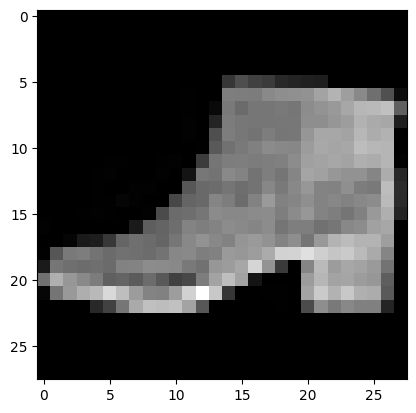

In [9]:
# Visualizando imagem original

data_iter = iter(train_dataloader)
images, _ = next(data_iter)
images = images.to(device)
img = images.cpu()[0].numpy()
img = img.squeeze() 
print('Dimensão imagem de entrada: ', img.shape)
plt.imshow(img, cmap='gray')

Visualizando camada: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Dimensão das imagens de saída: torch.Size([28, 28])


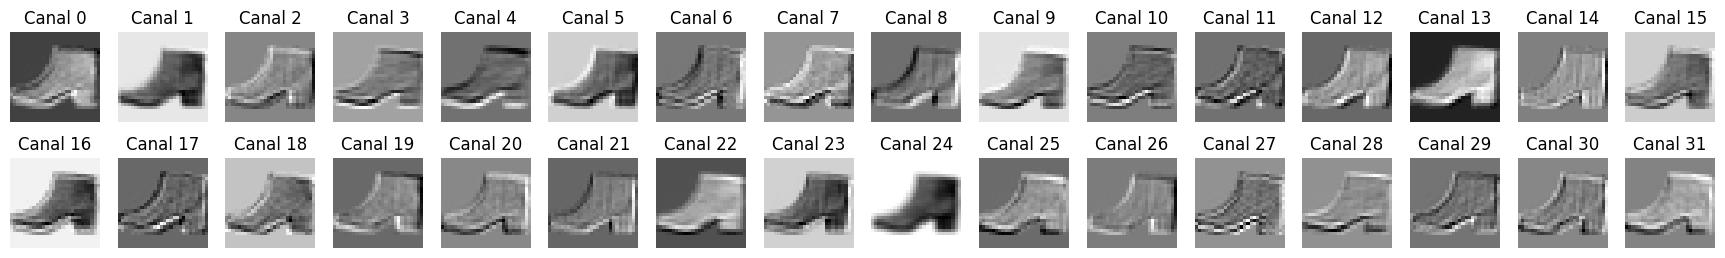

Visualizando após a aplicação da função ativação
Dimensão das imagens de saída: torch.Size([28, 28])


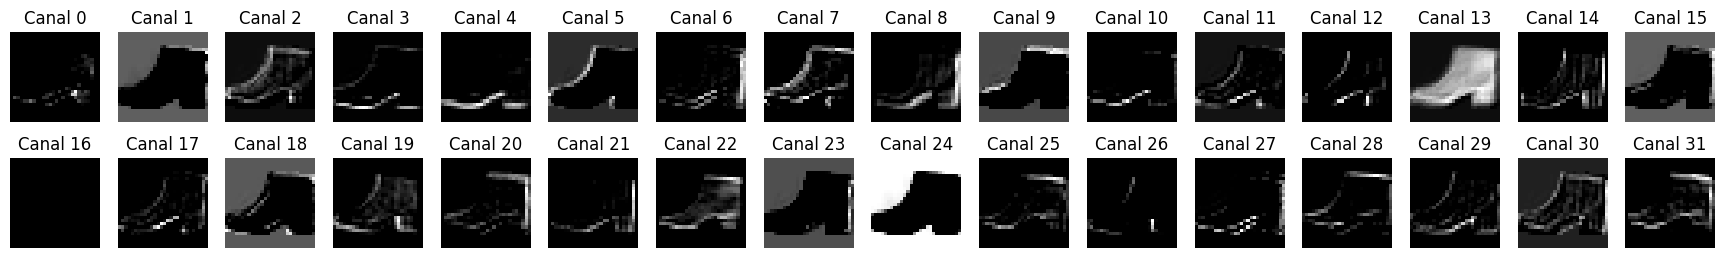

Visualizando camada: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Dimensão das imagens de saída: torch.Size([14, 14])


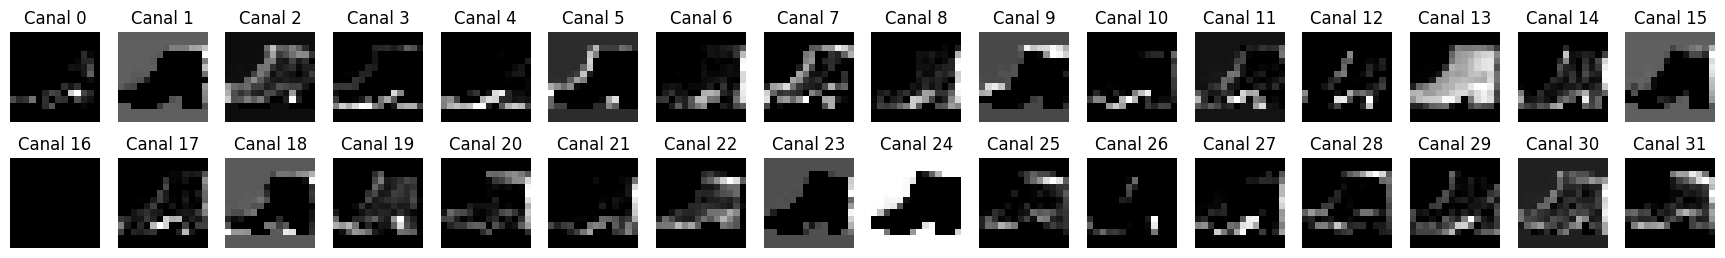

Visualizando camada: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Dimensão das imagens de saída: torch.Size([12, 12])


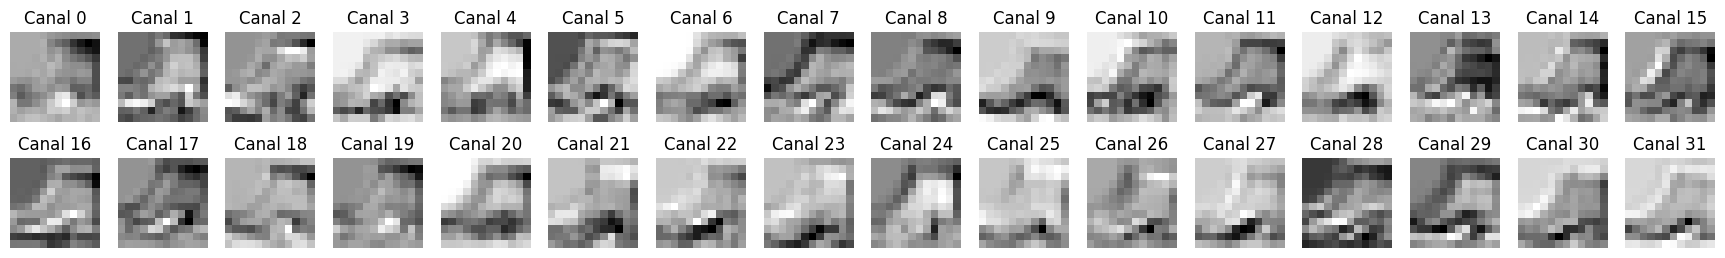

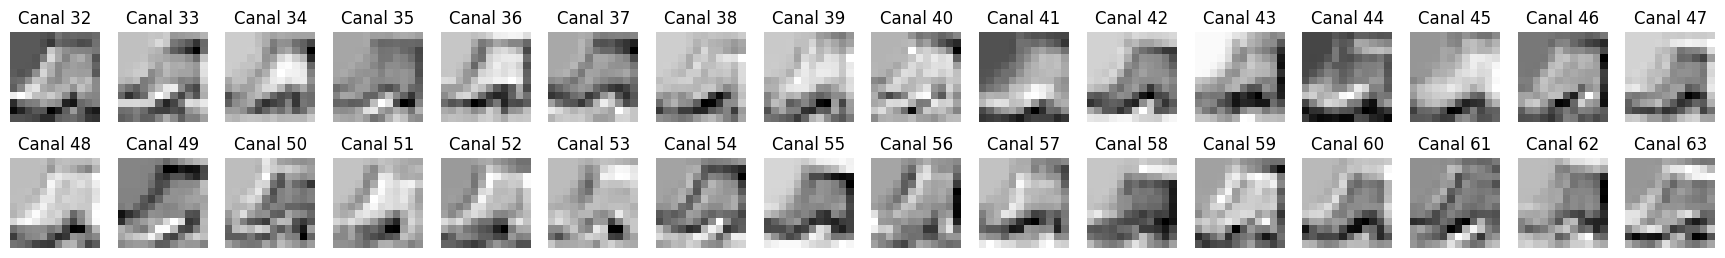

Visualizando após a aplicação da função ativação
Dimensão das imagens de saída: torch.Size([12, 12])


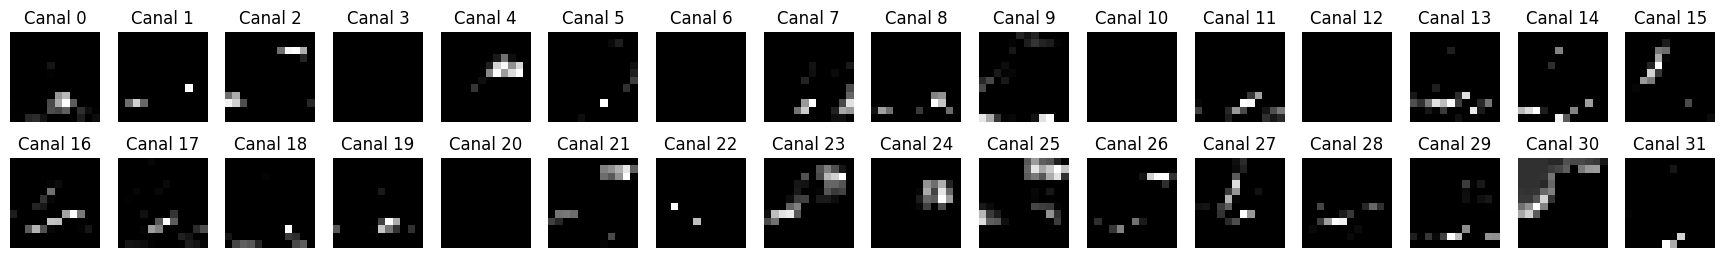

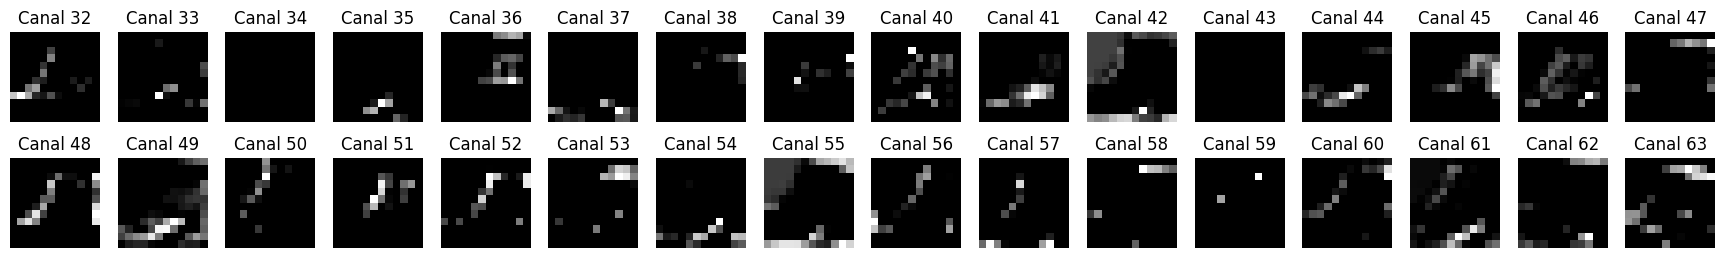

Visualizando camada: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Dimensão das imagens de saída: torch.Size([6, 6])


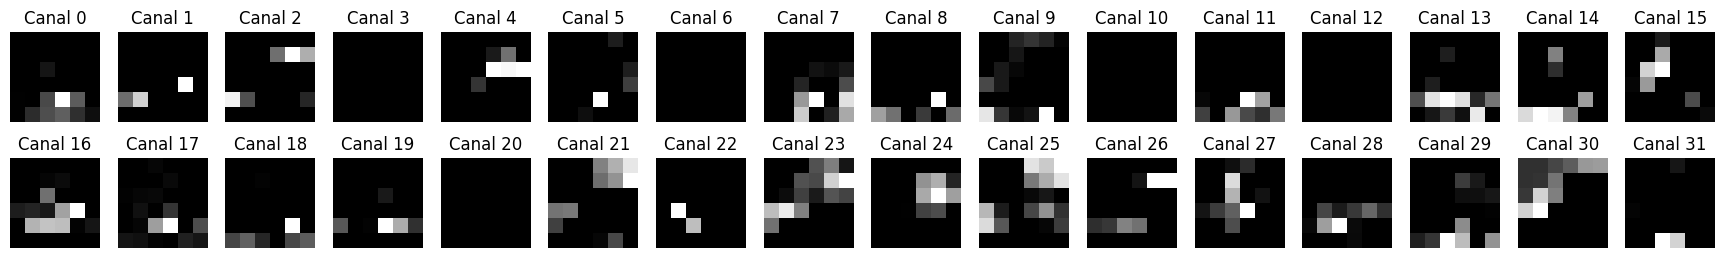

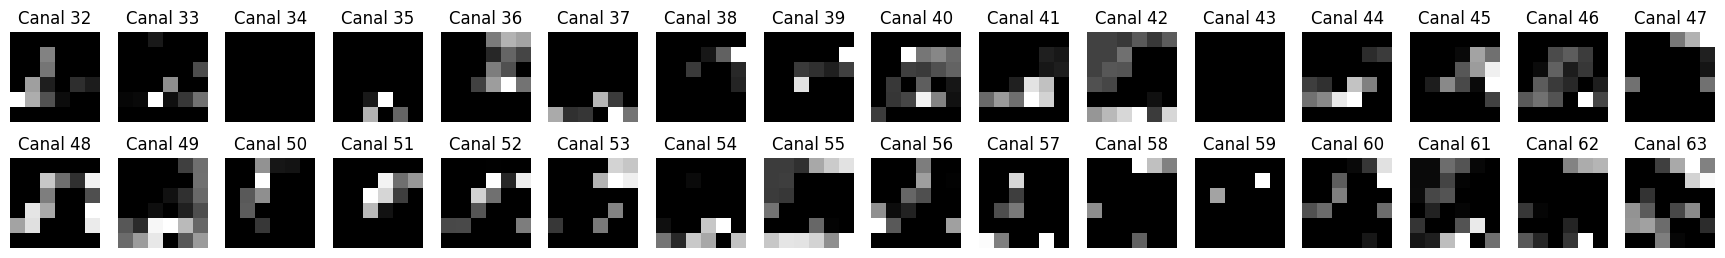

In [10]:
# Visualizando os canais de saída das camadas de convolução e pooling, além da aplicação da função de ativação ReLU

layers = [
    net.conv1,
    net.relu1,
    net.maxpool1,
    net.conv2,
    net.relu2,
    net.maxpool2,
]

out = images
for layer_idx, layer in enumerate(layers):

    out = layer(out)
    if layer_idx == 1 or layer_idx == 4:
        print(f'Visualizando após a aplicação da função ativação')
    else:
        layer_title = f"Visualizando camada: {layer}"
        print(layer_title)
    print('Dimensão das imagens de saída:', out[0][0].shape)

    fig_size = (22, 3)
    num_subplots_per_figure = 32
    num_channels = out.size(1)

    num_figures = (num_channels - 1) // num_subplots_per_figure + 1

    for figure_idx in range(num_figures):
        start_idx = figure_idx * num_subplots_per_figure
        end_idx = min(start_idx + num_subplots_per_figure, num_channels)

        fig = plt.figure(figsize=fig_size)

        for i in range(start_idx, end_idx):
            subplot_idx = i - start_idx + 1
            a = fig.add_subplot(2, 16, subplot_idx)
            channel_image = out[0, i].cpu().detach().numpy()  
            imgplot = plt.imshow(channel_image, cmap='gray')
            a.set_title(f'Canal {i}')
            a.axis('off')

        plt.show()

In [26]:
# Antes flatening
print(f'Dimensão antes do flatening: ', out[0].shape)

print(f'Dado exemplo: ', out[0])

Dimensão antes do flatening:  torch.Size([64, 6, 6])
Dado exemplo:  tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0228, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0014, 0.0000, 0.0776, 0.2677, 0.0967, 0.0000],
         [0.0011, 0.0470, 0.0818, 0.0996, 0.0492, 0.0152]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0990, 0.0000],
         [0.0422, 0.0810, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0943, 0.2167, 0.1479],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0

In [27]:
# Depois do flatenning
print(f'Dimensão após o flatenning: ',out.view(out.size(0), -1)[0].shape) # 64 * 6 * 6 = 2304

print(f'Dado exemplo: ', out.view(out.size(0), -1)[0])

Dimensão após o flatenning:  torch.Size([2304])
Dado exemplo:  tensor([0.0000, 0.0000, 0.0000,  ..., 0.0046, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
